In [793]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [794]:
#clustering
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
import time
from pandas.plotting import scatter_matrix
%matplotlib inline
sns.set_context('talk')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## Market Cluster Analysis

### Decide the number of games included in analysis

In [795]:
#data pre-processing
colnames=['user_id','game_title', 'behavior_name','value','temp'] 
users = pd.read_csv("steam-200k.csv",header=None,names=colnames,
                    usecols=['user_id','game_title', 'behavior_name','value'])
#remove duplicated purchase
users.drop_duplicates(subset=['user_id','game_title','behavior_name'], keep='first', inplace=True)
users.head()

,user_id,game_title,behavior_name,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


In [796]:
#number of users
condi = users.behavior_name == 'purchase'
users[condi].user_id.nunique()

12393

In [797]:
#number of games
users.game_title.nunique()

5155

**We decided to include the top 289 games by purchase time in user clusering analysis**   

Why 289?

In [798]:
# rank by number of purchase
condi = users.behavior_name == 'purchase'
top_games = users[condi].groupby(['game_title'])['user_id'].count().sort_values(ascending=False)
top_games.head()
#len(top_games)

game_title
Dota 2                             4841
Team Fortress 2                    2323
Unturned                           1563
Counter-Strike Global Offensive    1412
Half-Life 2 Lost Coast              981
Name: user_id, dtype: int64

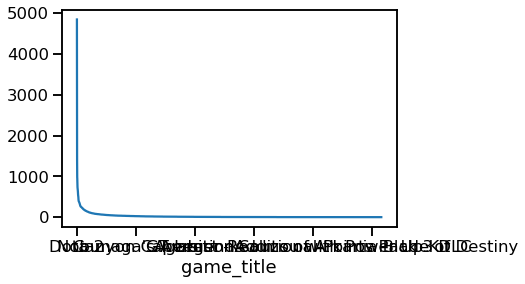

In [799]:
#overview
top_games.plot()

Number of purchase drops dramatically

In [800]:
#Filter out games less than 90 purchases (1% of total user population)
len(top_games.where(top_games >= 90).dropna())

289

**back to work**

In [801]:
#filter data set by top 289 games only
top_games_list = list(top_games.index[:289])
users = users[users.game_title.isin(top_games_list)]
users.user_id=users.user_id.astype('str')
users

,user_id,game_title,behavior_name,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
6,151603712,Fallout New Vegas,purchase,1.0
...,...,...,...,...
199991,128470551,Fallen Earth,play,2.4
199992,128470551,Magic Duels,purchase,1.0
199993,128470551,Magic Duels,play,2.2
199996,128470551,Grand Theft Auto Vice City,purchase,1.0


In [802]:
#output game list to manually assign genre to each game
#pd.Series(top_games_list).to_csv('top_games_list.csv')

### remove outliers 

In [803]:
from pandas.api.types import is_numeric_dtype
def remove_outlier(df):
    low = .05
    high = .95
    quant_df = df.quantile([low, high])
    for name in list(df.columns):
        if is_numeric_dtype(df[name]):
            df = df[ (df[name] < quant_df.loc[high, name])]
    return df

In [804]:
users = remove_outlier(users)
len(users)

110223

### Change the dataset to user vs hours played pivot table

In [805]:
user_play = users[users['behavior_name'] == 'play'].copy()
userbyitem = pd.DataFrame(index=user_play['user_id'].unique(), columns=user_play['game_title'].unique())

for i in range(len(user_play)):
    user_id = user_play.iloc[i]['user_id']
    game_title = user_play.iloc[i]['game_title']
    userbyitem.loc[user_id,game_title] = user_play.iloc[i]['value']
    
#take out users that haven't played at least 3 games
userbyitem = userbyitem[(~userbyitem.isnull()).sum(axis=1) >= 3]

#NA -> 0
userbyitem.fillna(0, inplace = True)

#total hrs played - added as a clusering factor to distinguish hardcore players/light players
userbyitem['Total_Hrs_Played'] = userbyitem.sum(axis=1)

In [817]:
#number of users finally
len(userbyitem)

2663

In [807]:
userbyitem.Total_Hrs_Played.describe()

count    2663.000000
mean      133.244686
std       167.079528
min         0.400000
25%        30.750000
50%        76.600000
75%       163.650000
max      1527.000000
Name: Total_Hrs_Played, dtype: float64

### Scale values to `range(0,100) `

In [808]:
scaler_mm = MinMaxScaler(feature_range = (0, 100))
userbyitem_mm = scaler_mm.fit_transform(userbyitem)
userbyitem_mm = pd.DataFrame(userbyitem_mm,columns = userbyitem.columns)

### Cluster

**determine optimal k** 

Use elbow plot and inertia as criterion  
Inertia: It is the sum of squared distances of samples to their closest cluster center   
[Elbow Method for optimal value of k in KMeans](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/)

In [809]:
def get_inertias(max_k, dataset):
    '''
    input max k value, dataset to do clustering on
    output inertias on different k
    '''
    inertia_dict = {}
    for k in range(1, max_k+1):
        model = KMeans(n_clusters=k).fit(dataset)
        inertia_dict[k] = model.inertia_    
    inertia_tuples = [(k, v) for k, v in inertia_dict.items()] 

    return inertia_tuples

In [810]:
def elbow_plot(inertias):
    plt.figure(figsize=(12, 8))
    plt.plot(*zip(*inertias))
    plt.title('Elbow Plot')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.xticks(range(1, len(inertias)+1))
    #plt.axvline(x=10, color = 'red')
    plt.grid(True)

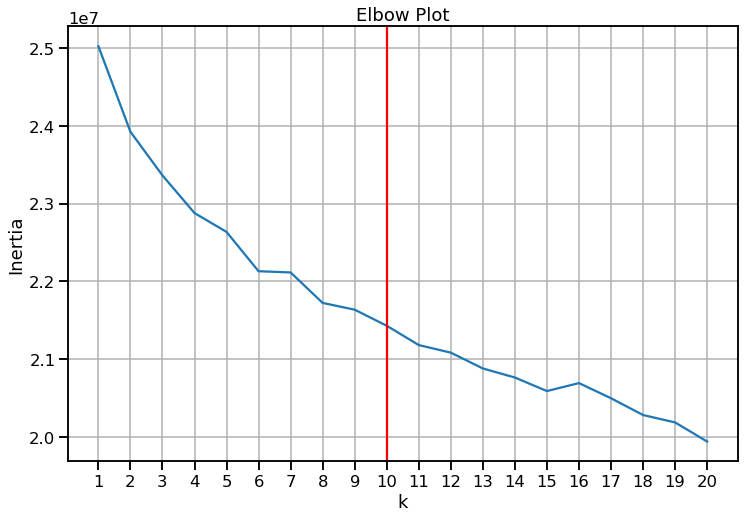

In [811]:
elbow_plot(get_inertias(20, userbyitem_mm))
plt.axvline(x=10, color = 'red')

**optimal k = 10**

In [827]:
#reset userbyitem_mm
scaler_mm = MinMaxScaler(feature_range=(0,100))
userbyitem_mm = scaler_mm.fit_transform(userbyitem)
userbyitem_mm = pd.DataFrame(userbyitem_mm,columns = userbyitem.columns)

k = 5
model = KMeans(n_clusters=k)
model.fit(userbyitem_mm)
userbyitem_mm['cluster'] = pd.Series(model.fit_predict(userbyitem_mm))
userbyitem_mm.head()

,Fallout New Vegas,Left 4 Dead 2,Path of Exile,Left 4 Dead,Team Fortress 2,Tomb Raider,Dead Island Epidemic,BioShock Infinite,Fallout 3 - Game of the Year Edition,Grand Theft Auto IV,...,Tropico 3 - Steam Special Edition,Magic Duels,Ragnarok Online 2,Fallen Earth,Starbound - Unstable,Dizzel,Patch testing for Chivalry,H1Z1 Test Server,Total_Hrs_Played,cluster
0,16.351351,11.710526,10.8,4.647887,3.733333,4.032258,3.181818,1.940299,1.142857,0.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.875671,3
1,0.000000,0.000000,0.0,0.000000,0.133333,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.437050,3
2,10.135135,93.421053,0.0,2.394366,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.372855,1
3,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.888903,0
4,0.000000,0.000000,0.0,0.000000,13.466667,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.901873,3


**sizes of clusters**

In [828]:
userbyitem_mm.groupby('cluster').size()

cluster
0     109
1     196
2     149
3    2037
4     172
dtype: int64

### Cluster details (game level)
1. The top 3 mostly played games
2. User stickiness on the top 3 games (mean hours played scaled in `range(0,100)`

In [829]:
def explain_cluster(data):
    '''
    input clustering data
    output the most 3 preferred genres in each cluster and statistics
    '''
    stats = data.groupby('cluster').mean().round(2)
    
    #rank every row
    stats1 = stats.drop(columns = 'Total_Hrs_Played')
    arr = np.argsort(-stats1.values, axis=1)
    row_rank = pd.DataFrame(stats1.columns[arr], index=stats1.index)
    row_rank = row_rank[[0, 1, 2]].rename(columns = {0:'Dominant Genre/Game', 
                                                        1:'2nd Preferred', 
                                                        2:'Might Also Play'})
    row_rank = row_rank.join(stats['Total_Hrs_Played'])
    row_rank = row_rank.rename(columns = {'Total_Hrs_Played':'User Stickness'})
    stats = stats.rename(columns = {'Total_Hrs_Played':'User Stickness'})

    #add cluster size
    sizes = data.groupby('cluster').size()
    sizes.name = 'Cluster Size'
    row_rank = row_rank.join(sizes)

    return stats,row_rank

In [830]:
ubi_stats,ubi_rank = explain_cluster(userbyitem_mm)
ubi_rank

,Dominant Genre/Game,2nd Preferred,Might Also Play,User Stickness,Cluster Size
cluster,,,,,
0,Call of Duty Modern Warfare 2,Call of Duty Modern Warfare 3 - Multiplayer,Call of Duty Modern Warfare 3,16.78,109
1,The Elder Scrolls V Skyrim,Borderlands 2,Left 4 Dead 2,35.96,196
2,Counter-Strike Global Offensive,Garry's Mod,Unturned,12.14,149
3,Garry's Mod,Unturned,Left 4 Dead 2,4.99,2037
4,Team Fortress 2,Unturned,Garry's Mod,13.48,172


In [831]:
ubi_stats

,Fallout New Vegas,Left 4 Dead 2,Path of Exile,Left 4 Dead,Team Fortress 2,Tomb Raider,Dead Island Epidemic,BioShock Infinite,Fallout 3 - Game of the Year Edition,Grand Theft Auto IV,...,Aura Kingdom,Tropico 3 - Steam Special Edition,Magic Duels,Ragnarok Online 2,Fallen Earth,Starbound - Unstable,Dizzel,Patch testing for Chivalry,H1Z1 Test Server,User Stickness
cluster,,,,,,,,,,,,,,,,,,,,,
0,3.03,12.85,0.54,3.09,2.66,2.57,0.33,1.56,0.00,5.59,...,0.00,0.55,0.28,0.00,0.02,0.00,0.00,0.08,0.00,16.78
1,12.28,16.67,2.83,4.96,6.72,7.80,1.04,10.83,3.86,8.86,...,0.59,1.26,0.49,0.19,0.03,0.14,0.30,0.78,0.07,35.96
2,0.86,5.11,1.47,1.84,4.48,1.22,0.81,0.60,0.34,2.08,...,0.36,0.01,0.27,0.01,0.01,0.27,0.01,0.30,0.03,12.14
3,0.95,2.86,0.69,0.50,2.44,0.91,0.26,0.70,0.28,0.59,...,0.16,0.06,0.22,0.09,0.11,0.03,0.11,0.01,0.07,4.99
4,2.09,5.81,0.59,0.33,57.91,0.53,0.31,1.57,0.86,3.07,...,0.01,0.09,0.30,0.01,0.05,0.58,0.58,0.05,0.14,13.48


### Cluster details (genre level)
1. The top 3 mostly preferred genres
2. User stickiness on the top 3 genres (sum of mean hours played scaled in `range(0,100)`

In [832]:
game_category = pd.read_csv('game_category.csv',index_col='Game')
gg_dict = game_category.to_dict()['Genre']

In [833]:
new_ubi = userbyitem_mm.copy()
new_ubi_cat = new_ubi.rename(columns=gg_dict)
new_ubi_cat = new_ubi_cat.drop('cluster', axis = 1)\
               .groupby(new_ubi_cat.drop('cluster', axis = 1).columns.values, axis = 1).sum().round(2)\
               .join(userbyitem_mm['cluster'])

In [834]:
genre_stats,genre_rank = explain_cluster(new_ubi_cat)
genre_rank.sort_values(['Dominant Genre/Game', '2nd Preferred'])

,Dominant Genre/Game,2nd Preferred,Might Also Play,User Stickness,Cluster Size
cluster,,,,,
1,Action,FPS,RPG,35.96,196
2,Action,FPS,Survival,12.14,149
3,Action,FPS,Survival,4.99,2037
4,Action,FPS,Survival,13.48,172
0,FPS,Action,Survival,16.78,109


In [835]:
genre_stats

,Action,Casual,Collectible Card Game,FPS,Free to Play,Puzzle,RPG,Sandbox,Simulation,Sports,Strategy,Survival,User Stickness,Tower Defence
cluster,,,,,,,,,,,,,,
0,66.12,2.01,0.28,204.32,0.21,13.24,18.37,15.53,4.53,2.22,17.48,38.85,16.78,0.31
1,278.07,13.68,0.49,162.97,0.41,37.80,102.72,41.19,27.97,7.95,89.03,76.34,35.96,11.29
2,118.04,5.25,0.27,47.07,0.24,5.44,13.29,17.83,6.85,4.59,21.21,32.41,12.14,1.06
3,31.60,1.67,0.22,30.64,0.22,3.88,9.54,7.80,4.02,1.41,12.29,13.55,4.99,0.65
4,122.19,6.29,0.30,75.46,0.09,5.83,16.21,19.72,5.33,2.98,19.46,36.25,13.48,2.29
